#在Fastai框架下基于BERT模型的中文文本分类


##Preparation

In [92]:
#安装pytorch下包含BERT预训练模型的库
!pip install pytorch-pretrained-bert

In [93]:
#引入必要的依赖包
import numpy as np
import pandas as pd

from pathlib import Path
from typing import *

import torch
import torch.optim as optim

from fastai import *
from fastai.vision import *
from fastai.text import *
from fastai.callbacks import *

In [94]:
#设置一个config类，便于参数配置与更改
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)

config = Config(
    testing=False,
    bert_model_name="bert-base-chinese", 
    #选用中文预训练模型：Chinese Simplified and Traditional, 12-layer, 768-hidden, 12-heads, 110M parameters
    max_lr=3e-5,
    epochs=1,
    use_fp16=False, #fastai里可以方便地调整精度，加快训练速度：learner.to_fp16()
    bs=8,
    max_seq_len=128, #选取合适的seq_length，较大的值可能导致训练极慢报错等
)

##Customize Tokenizer and Vocab

In [95]:
#pytorch_bert包提供了BertTokenizer类，从选取的模型中提取tok
from pytorch_pretrained_bert import BertTokenizer
bert_tok = BertTokenizer.from_pretrained(
    config.bert_model_name,
)

定制Tokenizer需要继承fastai的BaseTokenizer类，注意BERT会在sequence的首尾加上特殊token[CLS]和[SEP]，与fastai里的bos和eos有重合，所以在之后会有include_eos=Fasle的设置

In [96]:
class FastAiBertTokenizer(BaseTokenizer):
    """Wrapper around a BertTokenizer to be a BaseTokenizer in fastai"""
    def __init__(self, tokenizer: BertTokenizer, max_seq_len: int=128, **kwargs):
        self._pretrained_tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __call__(self, *args, **kwargs):
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length"""
        return ["[CLS]"] + self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2] + ["[SEP]"]

In [97]:
#最终的tokenizer
fastai_tokenizer = Tokenizer(
    tok_func=FastAiBertTokenizer(bert_tok, max_seq_len=config.max_seq_len), 
    pre_rules=[], 
    post_rules=[]
)

In [98]:
#check the vocab
list(bert_tok.vocab.items())[1090:1110]

[('冗', 1090),
 ('写', 1091),
 ('军', 1092),
 ('农', 1093),
 ('冠', 1094),
 ('冢', 1095),
 ('冤', 1096),
 ('冥', 1097),
 ('冨', 1098),
 ('冪', 1099),
 ('冬', 1100),
 ('冯', 1101),
 ('冰', 1102),
 ('冲', 1103),
 ('决', 1104),
 ('况', 1105),
 ('冶', 1106),
 ('冷', 1107),
 ('冻', 1108),
 ('冼', 1109)]

In [99]:
#设置vocab
fastai_bert_vocab = Vocab(list(bert_tok.vocab.keys()))

##Dataset

本次使用的数据集信息：

*   名称及出处：[ChnSentiCorp_htl_all](https://github.com/ZeroLeon/ChineseNlpCorpus/blob/master/datasets/ChnSentiCorp_htl_all/intro.ipynb)
*   数据概览： 7000 多条酒店评论数据，5000 多条正向评论，2000 多条负向评论
*   推荐实验： 情感/观点/评论 倾向性分析
*   数据来源： 携程网
*   原数据集： ChnSentiCorp_htl，由谭松波老师整理的一份数据集



In [100]:
#在colab下接入google drive，方便保存模型修改文件，使用其他kernel可跳过这一步
from google.colab import drive
drive.mount('/content/gdrive',force_remount = True)
base_dir = '/content/gdrive/My Drive/fastai'
path = Path(base_dir +'/data/htl_reviews')
# path.mkdir(parents=True,exist_ok=True)
os.chdir(path)

Mounted at /content/gdrive


In [ ]:
!wget https://github.com/SophonPlus/ChineseNlpCorpus/raw/master/datasets/ChnSentiCorp_htl_all/ChnSentiCorp_htl_all.csv

In [179]:
%cd /content/gdrive/MyDrive/fastai/data/htl_reviews
df_htl = pd.read_csv('ChnSentiCorp_htl_all.csv')[0:6000]

/content/gdrive/MyDrive/fastai/data/htl_reviews


In [180]:
#标签涵义：1代表正向评论，0代表负向评论
label_denotation = {1:'positive',0:'negative'}
df_htl.sample(10)

,label,review
4592,1,银川不大，携程上就只找到8个酒店，一眼看中了绿洲酒店，因为价格不错，248元就有豪华房，而且...
2027,1,"酒店有三种色调的房间,白色,米色和翠绿色,好象还有女士楼层看电梯里的介绍图片是粉红色的,挺有..."
5678,0,实话实说，此酒店实在不行，428的套房居然只是一张大床和一张小床，再加个桌子，浴缸没有，热水...
4159,1,酒店位置非常的好，客人每次都要点名入住。只是不知道为什么每次前台都为了吸烟区和非吸烟区和你捣...
5292,1,这家酒店应该不错，在北京这种价格还算合理。
5252,1,这家酒店性价比还是很高的，入住的是行政楼层单人间，给客户订的是行政楼层双人间，酒店内硬件设施...
2073,1,酒店的地理位置实在不错，所以从大堂开始就令人惊艳。城景房不但在房间可以看到上海的美景，就连于...
3895,1,大堂较小，房间不错，离地铁四号线非常近，交通比较方便。
1551,1,真如其他会员所说，隔音效果真的是一塌糊涂，隔着3件房间，都可以听到他们的电话铃音。并且强烈提...
4315,1,城堡酒店绝对是修身养性绝佳地方~~~我住的好的宾馆不少~~可以说在上海、深圳、大连、北京~~...


In [181]:
df_htl['label']

0       1
1       1
2       1
3       1
4       1
       ..
5995    0
5996    0
5997    0
5998    0
5999    0
Name: label, Length: 6000, dtype: int64

In [182]:
#分割训练集train与验证集val
from sklearn.model_selection import train_test_split

train, val = train_test_split(df_htl)

In [161]:
#check their size
print(train.shape,val.shape)

(4500, 1) (1500, 1)


In [183]:
#建立TextDataBunch
databunch = TextClasDataBunch.from_df(".", train, val,
                  tokenizer=fastai_tokenizer,
                  vocab=fastai_bert_vocab,
                  include_bos=False,
                  include_eos=False,
                  text_cols="review",
                  label_cols=['label'],
                  bs=config.bs,
                  collate_fn=partial(pad_collate, pad_first=False, pad_idx=0),
             )

/usr/local/lib/python3.7/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [184]:
databunch.show_batch()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


text,target
"[CLS] 环 境 不 错 有 家 的 感 觉 , 交 通 便 利 , 房 间 很 大 , 一 家 三 口 入 住 , 觉 得 有 点 浪 费 , 奥 运 期 间 住 5 个 人 也 可 以 ( 客 厅 沙 发 也 可 以 睡 觉 , 还 可 以 看 电 视 ) . 不 足 之 处 :",1
"[CLS] 订 的 是 行 政 套 房 , 比 较 干 净 . 性 价 比 尚 可 . 不 足 的 是 冰 箱 居 然 打 不 开 , 服 务 员 打 扫 卫 生 时 丢 三 拉 四 , 垃 圾 桶 套 桶 打 开 后 没 放 好 , 也 没 放 垃 圾 袋 . 大 堂 的 迎 宾 台",1
[CLS] 由 于 在 南 京 住 的 银 河 索 菲 特 感 觉 不 错 ， 所 以 这 次 来 成 都 退 了 喜 来 登 到 万 达 索 菲 特 ， 接 机 的 师 傅 和 行 李 员 都 非 常 的 不 错 ， 但 接 下 来 发 生 的 事 情 让 我 觉 得 非 常 气 愤,0
[CLS] 这 个 酒 店 和 曲 阜 都 给 人 留 下 了 永 远 难 忘 的 印 象 － － 垃 圾 ！ ！ 奉 劝 各 位 千 万 不 要 再 去 那 里 了 ， 保 你 后 悔 没 及 ！ 总 体 印 象 是 ： 无 论 酒 店 ， 商 店 ， 交 通 还 是 旅 游 景 点,0
[CLS] 上 网 免 费 ， 速 度 也 没 想 像 中 的 慢 ； 当 天 送 新 鲜 水 果 ， 那 个 桃 真 甜 ； 会 提 前 联 系 客 户 ， 确 认 接 站 信 息 ； 单 人 房 ， 床 大 小 还 算 中 等 ； 房 间 紧 凑 ， 没 有 书 桌 ， 但 在 浴,1


##Model and Loss Function

In [185]:
from pytorch_pretrained_bert.modeling import BertConfig, BertForSequenceClassification
bert_model = BertForSequenceClassification.from_pretrained(config.bert_model_name, num_labels=2)

100%|██████████| 382072689/382072689 [00:09<00:00, 41889146.93B/s]


In [186]:
#二分类问题选用CrossEntrypyLoss作为损失函数
loss_func = nn.CrossEntropyLoss()

In [187]:
#建立Learner(数据,预训练模型,损失函数)
learner = Learner(databunch, bert_model,loss_func=loss_func,metrics=accuracy)

In [188]:
#尝试寻找合适的最大学习率，这里使用了BERT原论文推荐的学习率3e-5作为默认值
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


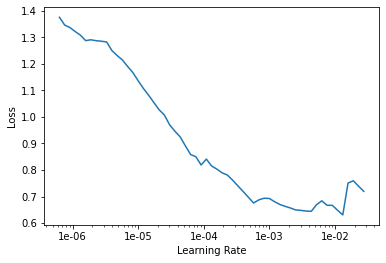

In [189]:
learner.recorder.plot(skip_end=20)

In [190]:
#开始训练
learner.fit_one_cycle(config.epochs, max_lr=config.max_lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.176117,0.170724,0.928667,01:57


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [191]:
learner.save(path/'htl_stage1')

In [194]:
#用样例测试下
learner.predict("设施老化，紧靠马路噪音太大，晚上楼上卫生间的水流声和空调噪音非常大，无法入眠")

(Category tensor(0), tensor(0), tensor([0.6205, 0.3795]))

In [206]:
learner.predict("差体验")

(Category tensor(0), tensor(0), tensor([0.7111, 0.2889]))

##What's Next?

本次task属于二元文本分类，数据集并不大，同时有相当一部分数据属于正负向情感混合的文本，容易拉低准确度，因此结果表现没那么抢眼，只能略窥BERT的强大。下一步计划使用更大的数据集做中文文本多标签分类，输出模型制作成一个能自动给文本打上情感标签的应用。